In [1]:
# --------------------------------------------------------------------------------
# STEP 1: 라이브러리 설치 및 임포트
# --------------------------------------------------------------------------------
print("라이브러리 설치 및 임포트 중...")

# SentencePiece 설치
!pip install sentencepiece -q

# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
import sentencepiece as spm
import warnings
warnings.filterwarnings('ignore')

라이브러리 설치 및 임포트 중...


In [2]:
# --------------------------------------------------------------------------------
# STEP 2: 데이터 로드 및 일반 대화 합성 데이터 생성
# --------------------------------------------------------------------------------
print("\nSTEP 2: 데이터 로드 및 일반 대화 합성 데이터 생성")
print("-" * 50)

def load_data():
    """위협성 분류 데이터 로드"""
    file_path = "~/work/project/dlthon/training.csv"
    
    try:
        df = pd.read_csv(file_path, encoding='utf-8')
        print(f"데이터 로드 성공: {df.shape}")
        return df
    except:
        try:
            df = pd.read_csv(file_path, encoding='cp949')
            print(f"데이터 로드 성공: {df.shape}")
            return df
        except Exception as e:
            print(f"데이터 로드 실패: {e}")
            return None

def create_test_data(train_df):
    """각 클래스별로 100개씩 추출해서 검증용 데이터 생성"""
    print("\n검증용 데이터 생성 중...")
    
    test_samples = []
    
    # 각 클래스별로 100개씩 랜덤 추출
    for class_idx in sorted(train_df['class'].unique()):
        class_data = train_df[train_df['class'] == class_idx]
        
        if len(class_data) >= 100:
            samples = class_data.sample(n=100, random_state=42)
        else:
            # 100개보다 적으면 전체 사용
            samples = class_data.copy()
            print(f"경고: 클래스 {class_idx}는 {len(samples)}개만 있음")
        
        test_samples.append(samples)
        print(f"클래스 {class_idx}: {len(samples)}개 추출")
    
    # 데이터 합치기
    test_df = pd.concat(test_samples, ignore_index=True)
    
    # idx와 text 컬럼만 남기기 (실제 test.csv 형식에 맞춤)
    test_df_final = pd.DataFrame({
        'idx': [f't_{i:03d}' for i in range(len(test_df))],
        'text': test_df['conversation'].values
    })
    
    # 검증용 파일 저장
    test_df_final.to_csv('~/work/project/dlthon/test.csv', index=False)
    print(f"검증용 데이터 생성 완료: {test_df_final.shape}")
    print(f"test.csv 파일 저장됨")
    
    # 원본 데이터에서 검증용으로 뽑힌 데이터 제거
    remaining_df = train_df.drop(test_df.index).reset_index(drop=True)
    print(f"남은 훈련 데이터: {remaining_df.shape}")
    
    return remaining_df, test_df_final

# 데이터 로드
train_df = load_data()
if train_df is not None:
    print(f"컬럼: {list(train_df.columns)}")
    print(f"첫 5개 행:")
    print(train_df.head())
    
    # 검증용 데이터 생성 (실제 테스트 환경 시뮬레이션)
    train_df, test_df_created = create_test_data(train_df)


STEP 2: 데이터 로드 및 일반 대화 합성 데이터 생성
--------------------------------------------------
데이터 로드 성공: (4929, 3)
컬럼: ['idx', 'class', 'conversation']
첫 5개 행:
   idx      class                                       conversation
0    0      협박 대화  지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1    1      협박 대화  길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2    2  기타 괴롭힘 대화  너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3    3      갈취 대화  어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4    4      갈취 대화  저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...

검증용 데이터 생성 중...
클래스 갈취 대화: 100개 추출
클래스 기타 괴롭힘 대화: 100개 추출
클래스 일반 대화: 100개 추출
클래스 직장 내 괴롭힘 대화: 100개 추출
클래스 협박 대화: 100개 추출
검증용 데이터 생성 완료: (500, 2)
test.csv 파일 저장됨
남은 훈련 데이터: (4429, 3)



STEP 3: 데이터 탐색 및 분석
--------------------------------------------------
기본 정보:
  데이터 크기: (4429, 3)
  컬럼명: ['idx', 'class', 'conversation']
  결측치: 0개
  타겟 컬럼: class
  텍스트 컬럼: conversation

클래스 분포:
클래스별 개수:
  클래스 갈취 대화: 843개 (19.0%)
  클래스 기타 괴롭힘 대화: 960개 (21.7%)
  클래스 일반 대화: 979개 (22.1%)
  클래스 직장 내 괴롭힘 대화: 858개 (19.4%)
  클래스 협박 대화: 789개 (17.8%)


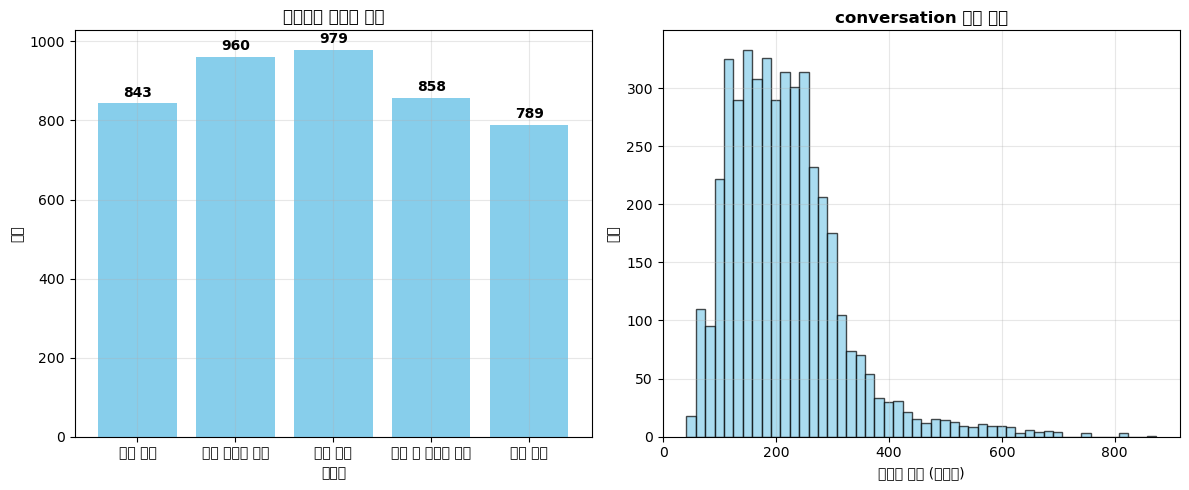


conversation 길이 통계:
  평균: 215.2자
  중간값: 201.0자
  최대: 874자
  최소: 41자
  표준편차: 102.0자


In [3]:
# --------------------------------------------------------------------------------
# STEP 3: 데이터 탐색 및 분석
# --------------------------------------------------------------------------------
print("\nSTEP 3: 데이터 탐색 및 분석")
print("-" * 50)

def simple_eda(df):
    """간단한 EDA 수행"""
    
    # 기본 정보
    print("기본 정보:")
    print(f"  데이터 크기: {df.shape}")
    print(f"  컬럼명: {list(df.columns)}")
    print(f"  결측치: {df.isnull().sum().sum()}개")
    
    # 실제 데이터 구조에 맞춘 컬럼 설정
    target_col = 'class'
    text_col = 'conversation'
    
    if target_col not in df.columns or text_col not in df.columns:
        print(f"예상 컬럼이 없습니다. 실제 컬럼: {list(df.columns)}")
        return df
    
    print(f"  타겟 컬럼: {target_col}")
    print(f"  텍스트 컬럼: {text_col}")
    
    # 타겟 분포 확인
    print(f"\n클래스 분포:")
    class_counts = df[target_col].value_counts().sort_index()
    print("클래스별 개수:")
    
    for i, count in class_counts.items():
        percentage = count/len(df)*100
        print(f"  클래스 {i}: {count:,}개 ({percentage:.1f}%)")
    
    # 시각화
    try:
        plt.figure(figsize=(12, 5))
        
        # 1. 클래스 분포 막대 그래프
        plt.subplot(1, 2, 1)
        bars = plt.bar(range(len(class_counts)), class_counts.values, color='skyblue')
        plt.title('클래스별 데이터 분포', fontsize=12, fontweight='bold')
        plt.xlabel('클래스')
        plt.ylabel('개수')
        plt.xticks(range(len(class_counts)), class_counts.index)
        
        # 막대 위에 숫자 표시
        for i, (bar, count) in enumerate(zip(bars, class_counts.values)):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(class_counts.values)*0.01,
                    str(count), ha='center', va='bottom', fontweight='bold')
        
        plt.grid(True, alpha=0.3)
        
        # 2. conversation 텍스트 길이 분포
        plt.subplot(1, 2, 2)
        df['text_length'] = df[text_col].astype(str).apply(len)
        plt.hist(df['text_length'], bins=50, color='skyblue', alpha=0.7, edgecolor='black')
        plt.title(f'{text_col} 길이 분포', fontsize=12, fontweight='bold')
        plt.xlabel('텍스트 길이 (문자수)')
        plt.ylabel('빈도')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 텍스트 길이 통계
        print(f"\n{text_col} 길이 통계:")
        print(f"  평균: {df['text_length'].mean():.1f}자")
        print(f"  중간값: {df['text_length'].median():.1f}자")
        print(f"  최대: {df['text_length'].max()}자")
        print(f"  최소: {df['text_length'].min()}자")
        print(f"  표준편차: {df['text_length'].std():.1f}자")
        
    except Exception as e:
        print(f"시각화 중 오류 발생: {e}")
        print("기본 정보만 출력합니다.")
    
    return df

# EDA 실행
if train_df is not None:
    simple_eda(train_df)

In [4]:
# --------------------------------------------------------------------------------
# STEP 4: 한국어 텍스트 전처리 (Java 불필요)
# --------------------------------------------------------------------------------
print("\nSTEP 4: 텍스트 전처리")
print("-" * 50)

def korean_preprocess(text):
    """
    순수 Python으로 한국어 텍스트 전처리
    - 정규식을 활용한 한국어 특화 전처리
    - Java나 외부 라이브러리 불필요
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # 1. HTML 태그 제거
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # 2. URL 제거
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)
    
    # 3. 이메일 제거
    text = re.sub(r'\S+@\S+', ' ', text)
    
    # 4. 숫자만 있는 단어 제거 (전화번호 등)
    text = re.sub(r'\b\d+\b', ' ', text)
    
    # 5. 특수문자 제거 (한글, 영어, 공백만 유지)
    text = re.sub(r'[^가-힣a-zA-Z\s]', ' ', text)
    
    # 6. 연속된 공백을 하나로
    text = re.sub(r'\s+', ' ', text)
    
    # 7. 앞뒤 공백 제거
    text = text.strip()
    
    # 8. 너무 짧은 텍스트 필터링
    if len(text) < 2:
        return ""
    
    # 9. 한국어 단어 단위로 분리 및 필터링
    words = text.split()
    filtered_words = []
    
    for word in words:
        # 길이 2 이상, 한글 포함된 단어만 유지
        if len(word) >= 2 and re.search(r'[가-힣]', word):
            filtered_words.append(word)
        # 영어 단어도 길이 3 이상이면 유지
        elif len(word) >= 3 and re.search(r'[a-zA-Z]', word):
            filtered_words.append(word.lower())
    
    return ' '.join(filtered_words)

def simple_korean_stopwords():
    """간단한 한국어 불용어 리스트"""
    stopwords = {
        # 조사
        '이', '가', '을', '를', '의', '에', '와', '과', '도', '만', '까지', '부터', '조차', '마저',
        '은', '는', '께서', '에서', '로', '으로', '에게', '한테', '보고', '더러',
        
        # 어미
        '하다', '되다', '있다', '없다', '이다', '아니다', '같다', '다르다',
        
        # 대명사
        '이것', '그것', '저것', '여기', '거기', '저기', '이곳', '그곳', '저곳',
        
        # 기타
        '것', '수', '등', '들', '및', '또는', '그리고', '하지만', '그런데', '그러나',
        '때문', '위해', '통해', '대해', '관해', '따라', '위하여', '하여'
    }
    return stopwords

def advanced_korean_preprocess(text):
    """불용어 제거를 포함한 고급 전처리"""
    # 기본 전처리
    text = korean_preprocess(text)
    
    if not text:
        return ""
    
    # 불용어 제거
    stopwords = simple_korean_stopwords()
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]
    
    return ' '.join(filtered_words)

# 전처리 적용
if train_df is not None:
    text_col = 'conversation'
    
    if text_col not in train_df.columns:
        print(f"오류: {text_col} 컬럼이 없습니다.")
        print(f"사용 가능한 컬럼: {list(train_df.columns)}")
    else:
        print(f"사용할 텍스트 컬럼: {text_col}")
        print("한국어 텍스트 전처리 진행 중...")
        
        # 고급 전처리 사용 (불용어 제거 포함)
        train_df['processed_text'] = train_df[text_col].apply(advanced_korean_preprocess)
        
        # 빈 텍스트 제거
        original_len = len(train_df)
        train_df = train_df[train_df['processed_text'].str.len() > 0].reset_index(drop=True)
        
        print(f"전처리 완료")
        print(f"  원본 데이터: {original_len}개")
        print(f"  처리 후: {len(train_df)}개")
        print(f"  제거된 데이터: {original_len - len(train_df)}개")


STEP 4: 텍스트 전처리
--------------------------------------------------
사용할 텍스트 컬럼: conversation
한국어 텍스트 전처리 진행 중...
전처리 완료
  원본 데이터: 4429개
  처리 후: 4429개
  제거된 데이터: 0개


In [5]:
# --------------------------------------------------------------------------------
# STEP 5: 검증 데이터 분할 (각 클래스별 균등 분할)
# --------------------------------------------------------------------------------
print("\nSTEP 5: 검증 데이터 분할")
print("-" * 50)

if train_df is not None:
    target_col = 'class'
    text_col = 'conversation'
    
    if target_col not in train_df.columns:
        print(f"오류: {target_col} 컬럼이 없습니다.")
        print(f"사용 가능한 컬럼: {list(train_df.columns)}")
    elif text_col not in train_df.columns:
        print(f"오류: {text_col} 컬럼이 없습니다.")
        print(f"사용 가능한 컬럼: {list(train_df.columns)}")
    else:
        print(f"타겟 컬럼: {target_col}")
        print(f"텍스트 컬럼: {text_col}")
        
        # 검증 데이터를 각 클래스별로 100개씩 추출
        print("\n검증 데이터 생성 중...")
        val_samples = []
        train_samples = []
        
        for class_idx in sorted(train_df[target_col].unique()):
            class_data = train_df[train_df[target_col] == class_idx]
            
            if len(class_data) >= 100:
                # 100개를 검증용으로
                val_data = class_data.sample(n=100, random_state=42)
                # 나머지를 훈련용으로
                train_data = class_data.drop(val_data.index)
            else:
                # 100개보다 적으면 80:20 비율로 분할
                val_size = max(1, int(len(class_data) * 0.2))
                val_data = class_data.sample(n=val_size, random_state=42)
                train_data = class_data.drop(val_data.index)
                print(f"경고: 클래스 {class_idx}는 {len(class_data)}개만 있어서 {val_size}개만 검증용으로 사용")
            
            val_samples.append(val_data)
            train_samples.append(train_data)
            print(f"클래스 {class_idx}: 훈련 {len(train_data)}개, 검증 {len(val_data)}개")
        
        # 데이터 합치기
        train_split = pd.concat(train_samples, ignore_index=True)
        val_split = pd.concat(val_samples, ignore_index=True)
        
        # X, y 설정
        X_train = train_split['processed_text']
        y_train = train_split[target_col]
        X_val = val_split['processed_text']
        y_val = val_split[target_col]
        
        print(f"\n데이터 분할 완료:")
        print(f"  훈련 데이터: {len(X_train)}개")
        print(f"  검증 데이터: {len(X_val)}개")
        
        # 검증 데이터 클래스 분포 확인
        print(f"\n검증 데이터 클래스 분포:")
        val_dist = y_val.value_counts().sort_index()
        for class_idx, count in val_dist.items():
            print(f"  클래스 {class_idx}: {count}개")


STEP 5: 검증 데이터 분할
--------------------------------------------------
타겟 컬럼: class
텍스트 컬럼: conversation

검증 데이터 생성 중...
클래스 갈취 대화: 훈련 743개, 검증 100개
클래스 기타 괴롭힘 대화: 훈련 860개, 검증 100개
클래스 일반 대화: 훈련 879개, 검증 100개
클래스 직장 내 괴롭힘 대화: 훈련 758개, 검증 100개
클래스 협박 대화: 훈련 689개, 검증 100개

데이터 분할 완료:
  훈련 데이터: 3929개
  검증 데이터: 500개

검증 데이터 클래스 분포:
  클래스 갈취 대화: 100개
  클래스 기타 괴롭힘 대화: 100개
  클래스 일반 대화: 100개
  클래스 직장 내 괴롭힘 대화: 100개
  클래스 협박 대화: 100개


In [6]:
# --------------------------------------------------------------------------------
# STEP 6: SentencePiece 토크나이저를 활용한 텍스트 벡터화
# --------------------------------------------------------------------------------
print("\nSTEP 6: SentencePiece 토크나이저를 활용한 텍스트 벡터화")
print("-" * 50)

from sklearn.preprocessing import LabelEncoder
from collections import Counter
import numpy as np
import tempfile
import os

if train_df is not None and 'X_train' in locals():
    
    class SentencePieceTokenizer:
        """SentencePiece 기반 토크나이저 클래스"""
        def __init__(self, vocab_size=3000, max_length=100):
            self.vocab_size = vocab_size
            self.max_length = max_length
            self.sp = spm.SentencePieceProcessor()
            self.model_path = None
            
        def train_tokenizer(self, texts):
            """SentencePiece 모델 훈련"""
            print("SentencePiece 모델 훈련 중...")
            
            # 임시 파일에 텍스트 저장
            with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.txt', encoding='utf-8') as f:
                for text in texts:
                    f.write(str(text) + '\n')
                temp_file = f.name
            
            # 모델 저장 경로
            self.model_path = tempfile.mktemp(suffix='.model')
            
            # SentencePiece 훈련
            spm.SentencePieceTrainer.train(
                input=temp_file,
                model_prefix=self.model_path.replace('.model', ''),
                vocab_size=self.vocab_size,
                model_type='bpe',  # Byte Pair Encoding
                max_sentence_length=1000,
                shuffle_input_sentence=True,
                character_coverage=0.995,
                user_defined_symbols=['<UNK>', '<PAD>'],
                pad_id=0,
                unk_id=1,
                bos_id=-1,  # Beginning of sentence (비활성화)
                eos_id=-1   # End of sentence (비활성화)
            )
            
            # 모델 로드
            self.sp.load(self.model_path)
            
            # 임시 파일 정리
            os.unlink(temp_file)
            
            print(f"SentencePiece 모델 훈련 완료: 어휘 크기 {self.sp.get_piece_size()}")
            
        def texts_to_sequences(self, texts):
            """텍스트를 시퀀스로 변환"""
            sequences = []
            
            for text in texts:
                # SentencePiece로 토큰화
                tokens = self.sp.encode_as_pieces(str(text))
                # 토큰을 ID로 변환
                token_ids = self.sp.encode_as_ids(str(text))
                
                # 최대 길이 제한
                if len(token_ids) > self.max_length:
                    token_ids = token_ids[:self.max_length]
                
                # 패딩
                while len(token_ids) < self.max_length:
                    token_ids.append(0)  # <PAD> ID
                
                sequences.append(token_ids)
            
            return np.array(sequences)
        
        def sequences_to_bow(self, sequences):
            """시퀀스를 Bag-of-Words 벡터로 변환"""
            bow_vectors = []
            
            for sequence in sequences:
                bow = np.zeros(self.sp.get_piece_size())
                for token_id in sequence:
                    if token_id > 0:  # <PAD> 제외
                        bow[token_id] += 1
                bow_vectors.append(bow)
            
            return np.array(bow_vectors)
        
        def get_vocab_sample(self, n=15):
            """어휘 샘플 반환"""
            vocab_sample = []
            for i in range(2, min(n+2, self.sp.get_piece_size())):  # <PAD>, <UNK> 제외
                piece = self.sp.id_to_piece(i)
                vocab_sample.append(piece)
            return vocab_sample
        
        def cleanup(self):
            """임시 파일 정리"""
            if self.model_path and os.path.exists(self.model_path):
                try:
                    os.unlink(self.model_path)
                    os.unlink(self.model_path.replace('.model', '.vocab'))
                except:
                    pass
    
    # SentencePiece 토크나이저 초기화 및 훈련
    tokenizer = SentencePieceTokenizer(vocab_size=3000, max_length=50)
    tokenizer.train_tokenizer(X_train)
    
    # 텍스트를 시퀀스로 변환
    print("텍스트를 시퀀스로 변환 중...")
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)
    
    # Bag-of-Words 벡터로 변환 (로지스틱 회귀용)
    print("Bag-of-Words 벡터로 변환 중...")
    X_train_bow = tokenizer.sequences_to_bow(X_train_seq)
    X_val_bow = tokenizer.sequences_to_bow(X_val_seq)
    
    print(f"SentencePiece 벡터화 완료:")
    print(f"  어휘 크기: {tokenizer.sp.get_piece_size():,}개")
    print(f"  최대 시퀀스 길이: {tokenizer.max_length}")
    print(f"  훈련 데이터 shape: {X_train_bow.shape}")
    print(f"  검증 데이터 shape: {X_val_bow.shape}")
    
    # 메모리 정리
    tokenizer.cleanup()
    
else:
    print("데이터 분할이 완료되지 않았습니다. 이전 단계를 확인해주세요.")



STEP 6: SentencePiece 토크나이저를 활용한 텍스트 벡터화
--------------------------------------------------
SentencePiece 모델 훈련 중...


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /tmp/tmp68_auref.txt
  input_format: 
  model_prefix: /tmp/tmpn8yxi792
  model_type: BPE
  vocab_size: 3000
  self_test_sample_size: 0
  character_coverage: 0.995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 1000
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <UNK>
  user_defined_symbols: <PAD>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: -1
  eos_id: -1
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_

SentencePiece 모델 훈련 완료: 어휘 크기 3000
텍스트를 시퀀스로 변환 중...
Bag-of-Words 벡터로 변환 중...
SentencePiece 벡터화 완료:
  어휘 크기: 3,000개
  최대 시퀀스 길이: 50
  훈련 데이터 shape: (3929, 3000)
  검증 데이터 shape: (500, 3000)



STEP 7: 로지스틱 회귀 모델 학습
--------------------------------------------------
2개 로지스틱 회귀 모델 학습 시작...

Logistic Regression (L1) 학습 중...
Logistic Regression (L1) 성능:
  F1-Score (Macro): 0.7774
  F1-Score (Weighted): 0.7774
  F1-Score (Micro): 0.7780
------------------------------------------------------------
Logistic Regression (L2) 학습 중...
Logistic Regression (L2) 성능:
  F1-Score (Macro): 0.7831
  F1-Score (Weighted): 0.7831
  F1-Score (Micro): 0.7840
------------------------------------------------------------

선택된 모델: Logistic Regression (L2)
   F1-Score (Macro): 0.7831

Logistic Regression (L2) 상세 분류 보고서:
              precision    recall  f1-score   support

       갈취 대화     0.7379    0.7600    0.7488       100
   기타 괴롭힘 대화     0.6727    0.7400    0.7048       100
       일반 대화     0.9804    1.0000    0.9901       100
 직장 내 괴롭힘 대화     0.8061    0.7900    0.7980       100
       협박 대화     0.7241    0.6300    0.6738       100

    accuracy                         0.7840       500
   macro 

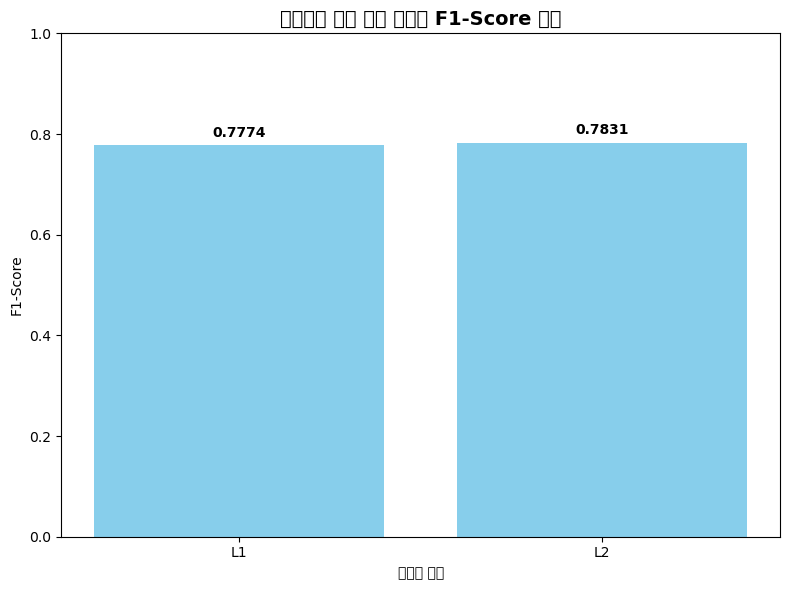


모델별 성능 비교:
--------------------------------------------------


In [7]:
# --------------------------------------------------------------------------------
# STEP 7: 로지스틱 회귀 모델 학습 (L1, L2 정규화 비교)
# --------------------------------------------------------------------------------
print("\nSTEP 7: 로지스틱 회귀 모델 학습")
print("-" * 50)

if train_df is not None and 'X_train_bow' in locals():
    # L1, L2 정규화만 사용하는 로지스틱 회귀 모델들
    models = {
        'Logistic Regression (L1)': LogisticRegression(
            random_state=42,
            max_iter=1000,
            C=1.0,
            penalty='l1',
            solver='liblinear'
        ),
        'Logistic Regression (L2)': LogisticRegression(
            random_state=42,
            max_iter=1000,
            C=1.0,
            penalty='l2',
            solver='liblinear'
        )
    }
    
    results = {}
    print(f"{len(models)}개 로지스틱 회귀 모델 학습 시작...\n")
    
    for name, model in models.items():
        print(f"{name} 학습 중...")
        
        # 모델 학습
        model.fit(X_train_bow, y_train)
        
        # 예측
        y_pred = model.predict(X_val_bow)
        y_pred_proba = model.predict_proba(X_val_bow)
        
        # 성능 평가
        f1_macro = f1_score(y_val, y_pred, average='macro')
        f1_weighted = f1_score(y_val, y_pred, average='weighted')
        f1_micro = f1_score(y_val, y_pred, average='micro')
        
        print(f"{name} 성능:")
        print(f"  F1-Score (Macro): {f1_macro:.4f}")
        print(f"  F1-Score (Weighted): {f1_weighted:.4f}")
        print(f"  F1-Score (Micro): {f1_micro:.4f}")
        
        # 결과 저장
        results[name] = {
            'model': model,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'f1_micro': f1_micro,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        print("-" * 60)
    
    # 모델 선택
    selected_model_name = max(results.keys(), key=lambda k: results[k]['f1_macro'])
    best_model = results[selected_model_name]['model']
    best_f1 = results[selected_model_name]['f1_macro']
    
    print(f"\n선택된 모델: {selected_model_name}")
    print(f"   F1-Score (Macro): {best_f1:.4f}")
    
    # 선택된 모델의 상세 분류 보고서
    print(f"\n{selected_model_name} 상세 분류 보고서:")
    best_pred = results[selected_model_name]['predictions']
    print(classification_report(y_val, best_pred, digits=4))
    
    # 성능 비교 시각화
    print(f"\n모델 성능 비교:")
    model_names = [name.split('(')[1].split(')')[0] for name in results.keys()]
    f1_scores = [results[name]['f1_macro'] for name in results.keys()]
    
    plt.figure(figsize=(8, 6))
    bars = plt.bar(range(len(model_names)), f1_scores, color='skyblue')
    plt.title('로지스틱 회귀 모델 설정별 F1-Score 비교', fontsize=14, fontweight='bold')
    plt.ylabel('F1-Score')
    plt.ylim(0, 1)
    plt.xticks(range(len(model_names)), model_names, rotation=0)
    plt.xlabel('정규화 방법')
    
    # 막대 위에 점수 표시
    for bar, score in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

In [8]:
# --------------------------------------------------------------------------------
# STEP 8: 검증용 데이터 성능 확인 함수 정의
# --------------------------------------------------------------------------------

def predict_test_data():
    """검증용 데이터로 모델 성능 확인"""
    test_file_path = "~/work/project/dlthon/test.csv"
    
    try:
        # 검증용 데이터 로드
        test_df = pd.read_csv(test_file_path, encoding='utf-8')
        print(f"검증용 데이터 로드: {test_df.shape}")
        print(f"컬럼: {list(test_df.columns)}")
    except:
        try:
            test_df = pd.read_csv(test_file_path, encoding='cp949')
            print(f"검증용 데이터 로드: {test_df.shape}")
            print(f"컬럼: {list(test_df.columns)}")
        except Exception as e:
            print(f"검증용 데이터 로드 실패: {e}")
            return None
    
    # 전처리
    print("검증용 데이터 전처리 중...")
    test_text_col = 'text'
    
    if test_text_col not in test_df.columns:
        print(f"오류: 검증용 데이터에 {test_text_col} 컬럼이 없습니다.")
        print(f"사용 가능한 컬럼: {list(test_df.columns)}")
        return None
    
    test_df['processed_text'] = test_df[test_text_col].apply(advanced_korean_preprocess)
    
    # 빈 텍스트 처리
    test_df['processed_text'] = test_df['processed_text'].replace('', 'empty_text')
    
    # SentencePiece 토크나이저로 벡터화
    print("SentencePiece 토크나이저로 벡터화 중...")
    test_sequences = tokenizer.texts_to_sequences(test_df['processed_text'])
    test_bow = tokenizer.sequences_to_bow(test_sequences)
    
    # 예측 확률 계산
    all_probabilities = best_model.predict_proba(test_bow)
    
    # 예측 클래스 추출 (가장 높은 확률의 클래스)
    predicted_classes = np.argmax(all_probabilities, axis=1)
    
    # 제출 형식 데이터프레임 생성
    submission_df = pd.DataFrame({
        'idx': test_df['idx'],
        'target': predicted_classes
    })
    
    # 파일 저장
    try:
        submission_df.to_csv('submission.csv', index=False)
        print(f"제출 파일 생성: submission.csv")
        
        # 파일 생성 확인
        import os
        if os.path.exists('submission.csv'):
            print("✅ submission.csv 파일 생성 확인됨")
        else:
            print("❌ submission.csv 파일 생성 실패")
        
        # 생성된 파일 내용 확인
        print("\nsubmission.csv head:")
        verification_df = pd.read_csv('submission.csv')
        print(verification_df.head())
        print(f"총 {len(verification_df)}개 행 생성됨")
        
    except Exception as e:
        print(f"파일 저장 오류: {e}")
        # 직접 데이터프레임 출력
        print("생성된 데이터프레임:")
        print(submission_df.head())
    
    # 예측 결과 분포 확인
    print(f"\n예측 결과 분포:")
    pred_counts = pd.Series(predicted_classes).value_counts().sort_index()
    for class_idx, count in pred_counts.items():
        print(f"  클래스 {class_idx}: {count}개 ({count/len(predicted_classes)*100:.1f}%)")
    
    return submission_df

# 검증용 데이터로 모델 성능 확인
if ('train_df' in locals() and train_df is not None and 
    'best_model' in locals() and 'tokenizer' in locals()):
    try:
        print("\n" + "="*60)
        print("STEP 8: 검증용 데이터로 모델 성능 확인")
        print("="*60)
        submission = predict_test_data()
    except Exception as e:
        print(f"검증 데이터 처리 중 오류: {e}")
        print("검증 파일이 없거나 경로를 확인해주세요.")
else:
    print("\n" + "="*60)
    print("STEP 8: 검증 단계 건너뛰기")
    print("="*60)
    print("모델 학습이 완료되지 않았거나 필요한 변수가 없습니다.")


STEP 8: 검증용 데이터로 모델 성능 확인
검증용 데이터 로드: (500, 2)
컬럼: ['idx', 'text']
검증용 데이터 전처리 중...
SentencePiece 토크나이저로 벡터화 중...
제출 파일 생성: submission.csv
✅ submission.csv 파일 생성 확인됨

submission.csv head:
     idx  target
0  t_000       0
1  t_001       0
2  t_002       0
3  t_003       0
4  t_004       4
총 500개 행 생성됨

예측 결과 분포:
  클래스 0: 94개 (18.8%)
  클래스 1: 99개 (19.8%)
  클래스 2: 101개 (20.2%)
  클래스 3: 97개 (19.4%)
  클래스 4: 109개 (21.8%)
